# Using UDEs to solve a damped SHO

## Generating the data

First, we'll want to generate data from a damped simple harmonic oscillator modeled by 

\begin{equation}
\frac{d^2x}{dt^2}+2\gamma\frac{dx}{dt}+\omega_0^2x=0
\label{DampedSHO}
\end{equation}

where $\gamma$ is the dampening factor and $\omega_0$ is the resonant frequency of the oscillator.

The solution to this ODE is obtained by simple using the trial solution of $x(t)=Ae^{kt}$. Plugging into the ODE we get:

\begin{equation}
\begin{split}
Ak^2e^{kt}+2\gamma Ake^{kt}+\omega_0^2Ake^{kt}&=0\\
Ae^{kt}\left(k^2+2\gamma k+\omega_0^2\right)&=0 \text{ Assume } Ae^{kt}\neq 0\\
k^2+2\gamma k+\omega_0^2&=0\\
k=\frac{-2\gamma}{2}\pm\frac{\sqrt{(2\gamma)^2-4(1)\omega_0^2}}{2}&\\
k=-\gamma\pm\sqrt{\gamma^2-\omega_0^2}
\end{split}
\label{DampedAuxEqn}
\end{equation}

So, the solution to the damped SHO is just

\begin{equation}
x(t)=A(e^{(-\gamma+\omega)t}+e^{(-\gamma-\omega)t})\text{ where } \omega=\sqrt{\gamma^2-\omega_0^2}
\label{DampedSHOSoln}
\end{equation}

and $A$ is the amplitude of oscillation.

Let's go ahead and use $\gamma=.1$, $\omega_0=.5$, $A=10$ for our values to get our data. First we'll need to load in all of our packages.

In [1]:
##using all of the packages we'll need

using Random
using Statistics
using Flux
using DiffEqFlux
using DataDrivenDiffEq
using LinearAlgebra
using DiffEqSensitivity
using Optim
using ModelingToolkit
using OrdinaryDiffEq
using Plots
using DifferentialEquations
using Measurements
using LaTeXStrings

At this point let's plot the analytic solution obtained from standard methods of solving ODEs.

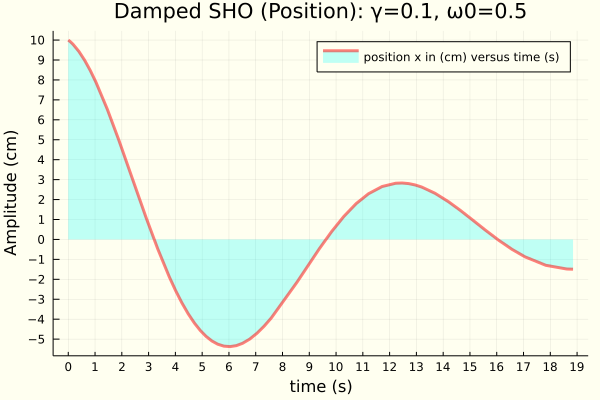

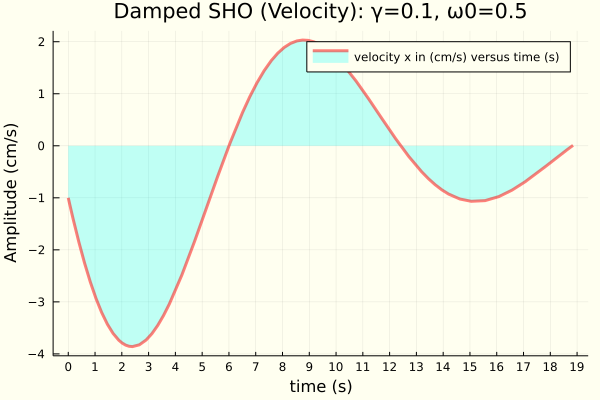

In [2]:
##Create a plot of the analytic solution of the damped SHO ODE.

#parameters of the damped SHO
x0 = 10;                       #Initial position
v0=0;                          #Initial velocity
ω0 = .5;                       #Resonant frequency of the undamped sysyem (γ=0)
γ = .1;                        #Damping coefficient
ω = sqrt(Complex(γ^2 - ω0^2)); #Frequency of the damped system
Ω1 = -γ + ω;                   #
Ω2 = -γ - ω;                   #

#x(t)=10*exp(-γ*t)*cos(ω*t);
x(t)=(x0/2)*(exp(Ω1*t) + exp(Ω2*t));
v(t)=(x0/2)*(Ω1*exp(Ω1*t) + Ω2*exp(Ω2*t));

#Now make the plot to display the solution (the position)

p1=plot(

#funtion to plot
x,
    
#label the line representing x(t).
label = "position x in (cm) versus time (s)",
    
#control the line properties by making it red, with an opacity of 50%, thickness of 3, and solid.
line = (:red, 0.5, 3, :solid),
    
#start the plot at t=0 and terminate it at 6π seconds.
0,
2π*3,
    
#label axes and title the plot.
ylabel = "Amplitude (cm)",
xlabel = "time (s)",
title = "Damped SHO (Position): γ=$(γ), ω0=$(ω0)",
    
#implement numbered ticks along x,y axes in increments of 1 from 0 to 20,10.
xticks = 0:1:20,
yticks = -x0:1:x0,

#fill the areas between the line x(t)=0 and the plot with a cyan coloring that has 25% opacity 
#and make the background of the plot ivory
fillrange = 0,
fillalpha = 0.25,
fillcolor = :cyan,
background_color = :ivory
)

#save the figure as a .png and .pdf
savefig("DampedSHOx.png")
savefig(p1,"DampedSHOx.pdf")

##Make the plot of the velocity

p2=plot(
v,
    
#label the line representing v(t).
label = "velocity x in (cm/s) versus time (s)",
    
#control the line properties by making it red, with an opacity of 50%, thickness of 3, and solid.
line = (:red, 0.5, 3, :solid),
    
#start the plot at t=0 and terminate it at 6π seconds.
0,
2π*3,
    
#label axes and title the plot.
ylabel = "Amplitude (cm/s)",
xlabel = "time (s)",
title = "Damped SHO (Velocity): γ=$(γ), ω0=$(ω0)",
    
#implement numbered ticks along x,y axes in increments of 1 from 0 to 20,10.
xticks = 0:1:20,
yticks = -x0:1:x0,

#fill the areas between the line x(t)=0 and the plot with a cyan coloring that has 25% opacity 
#and make the background of the plot ivory
fillrange = 0,
fillalpha = 0.25,
fillcolor = :cyan,
background_color = :ivory
)

##save the figure as a .png and .pdf
savefig("DampedSHOv.png")
savefig(p2,"DampedSHOv.pdf")

display(p1)
display(p2)

## Creating the UDE Model to discover damping

Now that we have the model data generated we want to learn the damping behavior without getting the solution completely from prior knowledge. When we found the solution to the damped SHO previously, we used a number of things:

<ol>
    <li>Newton's 2nd law, Hooke's Law, and assuming a damping force linearly proportional to the velocity (to form the differential equation.</li>
    <li>The well-known ansatz for a second order linear ODE with constant coefficients, $x(t)=Ae^{kt}$ and a tad bit of algebra.</li>
</ol>

The idea here is that often times in the real world you won't be able to simply look at the data, slap together an ODE with relevant boundary conditions, do some math and get an answer. However, you will have access to general properties of a system such as conservation of energy, newton's laws, and etc. The point is that while we don't know everything there is to know about the system under study, we (hopefully) <b>DO</b> know something about what's going on. So, let's use that knowledge when making our model. The rest we'll leave up to a neural network (or some other universal function approximator) to learn.

As a start, let's say we know that we have a data from a system involving an oscillator, we know that the data doesn't quite match up with the simple SHO, but it is SHO-like.

\begin{equation}
\frac{d^2x}{dt^2}+\omega_0^2x+NN=0
\end{equation}

Rather than one 2nd order ODE, we can recast this in terms of a system of two 1st order ODEs. <b>Renaming $x$ to $u_1$ and $v$ to $u_2$</b>

\begin{equation}
\begin{split}
\frac{du_1}{dt}&=u_2\\
\frac{du_2}{dt}&=-\omega_0^2u_1-NN=0
\end{split}
\end{equation}

where $NN$ is the neural network which we want to use to approximate $-2\gamma u_2$. 

First, we'll need to generate the position <b>data</b> that we wish to work with. So, 

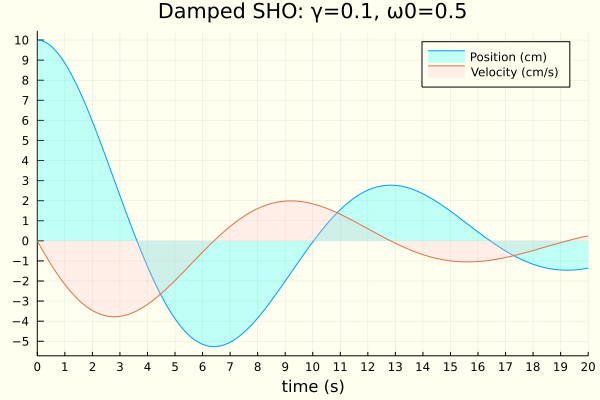

In [3]:
#Initial values of the oscillator
u0=[x0,v0]
#intial and final times for the solution
ti=0.0
tf=20.0
tspan=(ti,tf)

#This defines our DE system
function SHO(du,u,p,t)
    du[1]=u[2]
    du[2]=-ω0^2*u[1]-2γ*u[2]
end

prob = ODEProblem(SHO,u0,tspan)
sol = solve(prob)

#plot the data
p3=plot(
sol,
label=["Position (cm)" "Velocity (cm/s)"],
    
#label axes and title the plot.
xlabel = "time (s)",
title = "Damped SHO: γ=$(γ), ω0=$(ω0)",
    
#implement numbered ticks along x,y axes in increments of 1 from 0 to 20,10.
xticks = 0:1:20,
yticks = -x0:1:x0,

#fill the areas between the line x(t)=0 and the plot with a cyan coloring that has 25% opacity 
#and make the background of the plot ivory
fillrange = 0,
fillalpha = 0.25,
fillcolor = [:cyan :pink],
background_color = :ivory
)

##save the figure as a .png and .pdf
savefig("Data.png")
savefig(p3,"Data.pdf")

display(p3)

#output the solution to understand its structure
sol;

Now, we'll assign the 1st column of data to <b>x_true</b>, aka our true position and the 2nd column of <b>sol</b> we'll assign to <b>v_true</b> aka our true velocity. These will be the ground truth comparision against which we will test how accurate our model is.

In [4]:
x_true=sol[1,:];
v_true=sol[2,:];
sol.t;

Let's go ahead and generate our data that we'll use in the neural network to build our model.

In [5]:
du = [0.0, 0.0]

SHO([1.0, 1.0], [0.1, 0,0], 1.0, π)

-0.025

In [19]:
##Setup the data sample
t0=0;             #Start time of sampling
tf=6;             #End time of sampling
Δt=.3;            #Temporal spacing of sampling data
data_t=t0:Δt:tf;  
data=sol(data_t); #The sampled dataset

##Sample the position data and acceleration data
pos_data = [state[1] for state in sol(data_t)];
vel_data = [state[2] for state in sol(data_t)];
accel_data = [SHO(du, data[i], ω0, data_t[i]) for i ∈ 1:length(data_t)]


21-element Vector{Float64}:
 -2.5
 -2.327437206738794
 -2.114191752191627
 -1.8672801599772477
 -1.5940469926759633
 -1.3019764672115435
 -0.9985397752247114
 -0.6910038494857581
 -0.3863137357546734
 -0.0909554744383243
  0.18919300096865765
  0.4489071854798998
  0.6836980818078091
  0.8899162471637888
  1.064739313725047
  1.2061632196380447
  1.313051242865706
  1.3851091263960396
  1.4227862324991927
  1.4272374520004694
  1.400305559669581

Now we need to build the neural network, let's call it <b>layers</b>, that we'll use to as a stand-in for the damping term in the ODE.

In [21]:
layers=Chain(x->[x],Dense(1,32,tanh),Dense(32,1),first)

Chain(#33, Dense(1, 32, tanh), Dense(32, 1), first)

Let's go ahead and make the first loss function, this will be a simple mean-squared error between what our neural network predicts and what the actual true solution is.

In [22]:
loss()=sum(abs2,layers(pos_data[i]).-accel_data[i] for i in 1:length(pos_data));
loss()

81.21250037896785

Now we will add in the physics to the machine learning by way of Hooke's Law $F=-kx$ or since we're using acceleration in this case $a=-\omega_0^2x$

In [23]:
rand_pos = [x0*(2rand()-1) for i in 1:100] # random values in [-x0,x0]
phy_loss() = sum(abs2,layers(x) - (-ω0^2*x) for x in rand_pos);
phy_loss()


427.6554111743035

Here we will combine the simple loss function with the physics informed one.

In [24]:
λ=.01;
total_loss()=loss()+λ*phy_loss();
total_loss()

85.48905449071088

Now we will train the network and see how well we did.

85.48905449071088

NaN

NaN

NaN

NaN

NaN

NaN

NaN

NaN

NaN

NaN

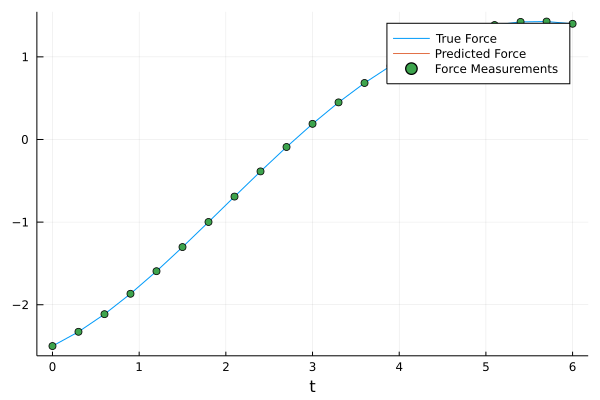

In [25]:
##Setup the data sample
t0plot=0;             #Start time of sampling
tfplot=20;             #End time of sampling
Δtplot=.01;            #Temporal spacing of sampling data
data_plot=t0:Δt:tf;  
plotit=sol(data_plot); #The sampled dataset

##Sample the position data and acceleration data
pos_plot = [state[1] for state in sol(data_plot)];
vel_plot = [state[2] for state in sol(data_plot)];
accel_plot =[SHO(du, plotit[i], ω0, data_plot[i]) for i ∈ 1:length(data_plot)]

##Train the model
opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(total_loss())
  end
end
display(total_loss())
Flux.train!(total_loss, Flux.params(layers), data, opt; cb=cb)

learned_accel_plot = layers.(pos_plot)

plot(data_plot,accel_plot,xlabel="t",label="True Force")
plot!(data_plot,learned_accel_plot,label="Predicted Force")
scatter!(data_t,accel_data,label="Force Measurements")